# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1130]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [1131]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [1132]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [1133]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [1134]:
azdias.shape

(891221, 85)

azdias data contains 85 features and 891221 entries. <br>
data types in azdias inlucde int64, float64 and object. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [1135]:
# create a duplicate dataframe for cleaning
azdias_clean = azdias.copy()
feat_info_clean = feat_info.copy()

In [1136]:
# store data types of each column into feat_info_clean
feat_info_clean['data_type']=np.array([azdias[column].dtype for column in azdias.columns])

In [1137]:
# find unique values of codes for missing or unknown data
feat_info_clean['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

Identify missing or unknown data values and convert them to NaNs.

In [1138]:
# define a function to convert the string to lists
def code_for_unknown(string, data_type):
    '''convert a string that looks like a list of integers to list of integers'''
    if string == '[]':
        return None    
    elements = string[1:-1].split(',')
    if data_type == 'object':
        return elements
    if data_type=='int64':
        return [int(element) for element in elements]
    if data_type == 'float64':
        return [float(element) for element in elements]

In [1139]:
# store codes for missing values of each column into the data frame feat_info_clean
feat_info_clean['missing_codes']=[code_for_unknown(element, data_type) for element, data_type in zip(feat_info_clean['missing_or_unknown'], feat_info_clean['data_type'])]          

In [1140]:
# in the new data frame, replaces codes for missing values with NaN
for i, column in enumerate(feat_info_clean['attribute']):
    if feat_info_clean.loc[i,'missing_codes'] is not None:
        azdias_clean[column].replace(feat_info_clean.loc[i,'missing_codes'], np.NaN, inplace=True) 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [1141]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_clean.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

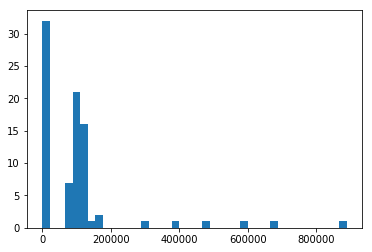

In [1142]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(azdias_clean.isnull().sum(), bins=40);

columns that have more than 200000 missing values should be considered outliers.

In [1145]:
# find columns that have more 200000 missing values
columns_to_drop = list(num_missing[num_missing['after_replacing'] > 200000].index)
columns_to_drop

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

Remove the outlier columns from the dataset.

In [1146]:
# remove these columns from azdias_clean
azdias_clean.drop(columns_to_drop, inplace=True, axis=1)

#remove these columns from feat_info_clean
#find the index of these columns
index_to_drop = [feat_info_clean[feat_info_clean['attribute']==col].index for col in columns_to_drop]
#drop the rows that match the indexes
for ind in index_to_drop:
    feat_info_clean.drop(index=ind, inplace=True)

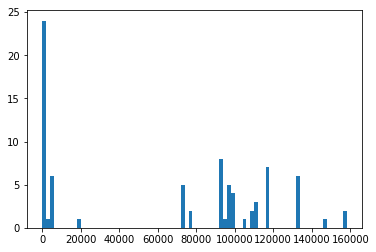

In [1147]:
# view distribution of missing values again
plt.hist(azdias_clean.isnull().sum(), bins=azdias_clean.shape[1]);

#### Discussion 1.1.2: Assess Missing Data in Each Column

These columns have more than 200000 missing values and they were dropped from the data from: <br>
'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

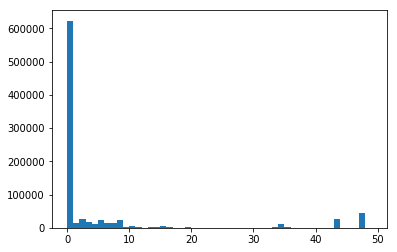

In [1148]:
# How much data is missing in each row of the dataset?
# number of missing values of each row is saved to a new column 'num_missing_values'
azdias_clean['num_missing_values'] = azdias_clean.isnull().sum(axis=1)
plt.hist(azdias_clean['num_missing_values'], bins=azdias_clean['num_missing_values'].max());

divide the data into two subsets based on the number of missing values in each row

In [1014]:
# threshold of number of missing values is set to 5

azdias_clean_lessNaN = azdias_clean[azdias_clean['num_missing_values'] <=5].copy()
azdias_clean_moreNaN = azdias_clean[azdias_clean['num_missing_values'] > 5].copy()

In [1015]:
azdias_clean_lessNaN.shape, azdias_clean_moreNaN.shape

((719624, 80), (171597, 80))

Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

In [1016]:
columns = ['BALLRAUM', 'EWDICHTE', 'WOHNLAGE', 'KONSUMNAEHE', 'GEBAEUDETYP']

In [1017]:
# define a function to compare distribution of a column in two datasets
def compare_distrib(col_name, col1, col2):
    '''compare distribution of column1 and column2. 
    col_name is the name of column.
    column1 is values of the column from data set with few or no missing values. 
    column2 is values of the column from data set with more missing values'''
    col1_val_counts = col1.value_counts()
    col1_x = col1_val_counts.index
    col1_y = col1_val_counts/sum(col1_val_counts)
    plt.bar(x=col1_x, height=col1_y, alpha=0.5,
             color='red', label='dataset with less missing values')
    
    col2_val_counts = col2.value_counts()
    col2_x = col2_val_counts.index
    col2_y = col2_val_counts/sum(col2_val_counts)
    plt.bar(x=col2_x, height=col2_y, alpha=0.5,
             color='green', label='dataset with more missing values')
    plt.xlabel('unique values')
    plt.ylabel('percentage')
    plt.legend()
    plt.title('compare ' + col_name + ' of datasets of less and more missing values')

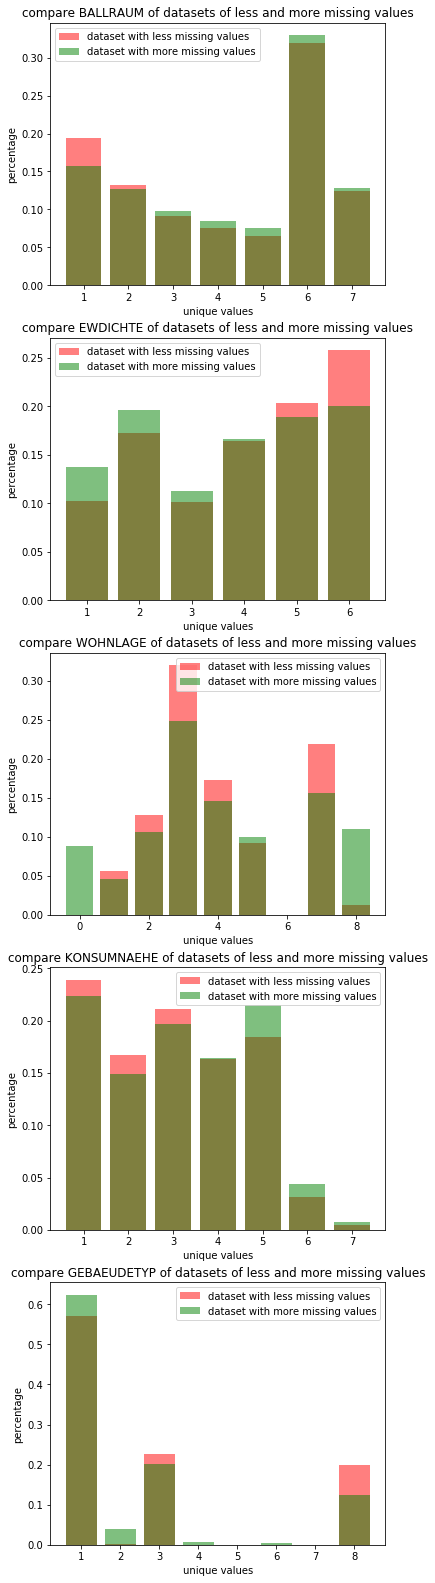

In [1018]:
plt.figure(figsize=(6,28))
for i,col in enumerate(columns):
    plot_index=int('5'+'1'+str(i+1))
    plt.subplot(plot_index)
    compare_distrib(col, azdias_clean_lessNaN[col], azdias_clean_moreNaN[col])

In [1019]:
# drop the column 'num_missing_values' from the 3 data frames
azdias_clean.drop(columns = ['num_missing_values'], inplace = True)
azdias_clean_lessNaN.drop(columns = ['num_missing_values'], inplace = True)
azdias_clean_moreNaN.drop(columns = ['num_missing_values'], inplace = True)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Among the 5 randomly picked columns, 2 columns, 'EWDICHTE', 'WOHNLAGE', show very different distributions between the 2 datasets. Other 3 columns show similar distribution. Based on observation made on these 5 columns, I would say that datasets with few or no missing values do have different distributions from the dataset with more missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [1020]:
# How many features are there of each data type?
feat_info_clean['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

In [1021]:
# find the categorical columns
categorical_columns = feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute']

In [1022]:
# create a dictionary of categorical columns with their number of levels
cat_col_values = {col: azdias[col].value_counts().shape[0] for col in categorical_columns}

In [1023]:
cat_col_values

{'ANREDE_KZ': 2,
 'CJT_GESAMTTYP': 6,
 'FINANZTYP': 6,
 'GFK_URLAUBERTYP': 12,
 'GREEN_AVANTGARDE': 2,
 'LP_FAMILIE_FEIN': 12,
 'LP_FAMILIE_GROB': 6,
 'LP_STATUS_FEIN': 10,
 'LP_STATUS_GROB': 5,
 'NATIONALITAET_KZ': 4,
 'SHOPPER_TYP': 5,
 'SOHO_KZ': 2,
 'VERS_TYP': 3,
 'ZABEOTYP': 6,
 'GEBAEUDETYP': 7,
 'OST_WEST_KZ': 2,
 'CAMEO_DEUG_2015': 10,
 'CAMEO_DEU_2015': 45}

In [1024]:
# view encodings of the binary columns
azdias_clean_lessNaN['ANREDE_KZ'].unique(), azdias_clean_lessNaN['SOHO_KZ'].unique(), azdias_clean_lessNaN['OST_WEST_KZ'].unique()

(array([2, 1], dtype=int64), array([1., 0.]), array(['W', 'O'], dtype=object))

binary categorical columns are :'ANREDE_KZ', 'SOHO_KZ', 'OST_WEST_KZ'. <br>
values of the column **'OST_WEST_KZ'** are not numerical. It needs to be reencoded. <br>
all other categorical columns are multi-level. <br>
columns that have 10 or more levels are to be dropped.

reencode 'OST_WEST_KZ' with integer 1 for West Germany, and 2 for East Germany

In [1025]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_clean_lessNaN['OST_WEST_KZ_num'] = (azdias_clean_lessNaN['OST_WEST_KZ'] == 'W') *1 +(azdias_clean_lessNaN['OST_WEST_KZ'] == 'O') *2

# drop the column 'OST_WEST_KZ', and rename 'OST_WEST_KZ_num' to 'OST_WEST_KZ'
azdias_clean_lessNaN.drop(columns = ['OST_WEST_KZ'], inplace=True)
azdias_clean_lessNaN.rename(columns = {'OST_WEST_KZ_num': 'OST_WEST_KZ'}, inplace=True)

# drop row of 'OST_WEST_KZ' from feat_info_clean
ind = feat_info_clean[feat_info_clean['attribute']=='OST_WEST_KZ'].index
feat_info_clean.drop(index=ind, inplace=True)

# check if coding were successfully changed
azdias_clean_lessNaN['OST_WEST_KZ'].value_counts()

1    564460
2    155164
Name: OST_WEST_KZ, dtype: int64

drop columns that have 3 or more categorical levels

In [1053]:
multi_lev_cols

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [1026]:
# find columns that have more than 3 categorical levels
multi_lev_cols = [col for col in cat_col_values if cat_col_values[col] >= 3]

# drop the multi_lev_cols columns from azdias_clean_lessNaN
azdias_clean_lessNaN.drop(columns = multi_lev_cols, inplace = True)

# drop these info for these columns from feat_info_clean
index_to_drop = [feat_info_clean[feat_info_clean['attribute']==col].index for col in multi_lev_cols]
for ind in index_to_drop:
    feat_info_clean.drop(index=ind, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

After dropping columns that have more than 200000 missing values, 18 of the remaining columns contain categorical values. <br>
 - These 2 columns contain binary categorical values that are numerical, and I am keeping them: 'ANREDE_KZ', 'SOHO_KZ'.  <br>
 - The 'OST_WEST_KZ' column is encoded with non-numerical values. I re-encoded this column using integer 1 for West Germany and 2 for East Germany. <br>
 - Categorical columns that contain 3 or more levels are dropped

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

##### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
Values of "PRAEGENDE_JUGENDJAHRE" are floats. I need to convert them to integers before proceeding. <br>
Values 1,3,5,8,10,12,14 "PRAEGENDE_JUGENDJAHRE" encode mainstream movement, and other values encode avantgarde movement.<br>
The decades are 40,50,60,70,80 and 90

In [1027]:
#convert dtype to int, fill NaN with 0
azdias_clean_lessNaN["PRAEGENDE_JUGENDJAHRE"].fillna(0, inplace=True)
azdias_clean_lessNaN["PRAEGENDE_JUGENDJAHRE"] = azdias_clean_lessNaN["PRAEGENDE_JUGENDJAHRE"].astype(int)

In [1028]:
# create a dictionary that relate encoding to decades:
dec_dic={1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 
         9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90,
        0: np.NaN}

# create a dictionary that relate encoding to movements:
mov_dic={1:1, 2:2, 3:1, 4:2, 
         5:1, 6:2, 7:2, 8:1, 
         9:2, 10:1, 11:2, 12:1,
         13:2, 14:1, 15:2,
        0: np.NaN}

# create a new column 'movemnet_decade'
azdias_clean_lessNaN['movement_decade'] = azdias_clean_lessNaN["PRAEGENDE_JUGENDJAHRE"]
azdias_clean_lessNaN['movement_decade'] = azdias_clean_lessNaN['movement_decade'].apply(lambda x: dec_dic[x])

# create a new column 'movemnet'
azdias_clean_lessNaN['movement'] = azdias_clean_lessNaN["PRAEGENDE_JUGENDJAHRE"]
azdias_clean_lessNaN['movement'] = azdias_clean_lessNaN['movement'].apply(lambda x: mov_dic[x])

In [1029]:
# check values of the new columns
azdias_clean_lessNaN['movement_decade'].unique(), azdias_clean_lessNaN['movement'].unique()

(array([90., 70., 50., 80., 60., nan, 40.]), array([ 1.,  2., nan]))

In [1030]:
# drop the column "PRAEGENDE_JUGENDJAHRE"
azdias_clean_lessNaN.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)

# drop info for "PRAEGENDE_JUGENDJAHRE" from feat_info_clean
ind = feat_info_clean[feat_info_clean['attribute']=="PRAEGENDE_JUGENDJAHRE"].index
feat_info_clean.drop(index=ind, inplace=True)

##### Investigate "CAMEO_INTL_2015" and engineer two new variables.
For each code of this column, the tens digit represents wealth, and the one digit represents life stage. Currently the values are strings.

In [1031]:
azdias_clean_lessNaN["CAMEO_INTL_2015"].unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '33',
       '12', '41', '25', nan, '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [1032]:
# replace NaN with 0 
azdias_clean_lessNaN["CAMEO_INTL_2015"].replace(np.NaN, '00', inplace=True)
azdias_clean_lessNaN['CAMEO_INTL_2015'].unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '33',
       '12', '41', '25', '00', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [1033]:
# create a new column 'wealth' whose value is the tens digit of the value of 'CAMEO_INTL_2015'
azdias_clean_lessNaN['wealth'] = azdias_clean_lessNaN['CAMEO_INTL_2015']
azdias_clean_lessNaN['wealth'] = azdias_clean_lessNaN['wealth'].apply(lambda x: int(x[0]))
azdias_clean_lessNaN['wealth'].replace(0, np.NaN, inplace=True)

# create a new column 'life_stage' whose value is the ones digit of the value of 'CAMEO_INTL_2015'
azdias_clean_lessNaN['life_stage'] = azdias_clean_lessNaN['CAMEO_INTL_2015']
azdias_clean_lessNaN['life_stage'] = azdias_clean_lessNaN['life_stage'].apply(lambda x: int(x[1]))
azdias_clean_lessNaN['life_stage'].replace(0, np.NaN, inplace=True)

# drop the column 'CAMEO_INTL_2015'
azdias_clean_lessNaN.drop(columns=['CAMEO_INTL_2015'], inplace=True)

# drop infor for 'CAMEO_INTL_2015' from feat_info_clean
ind = feat_info_clean[feat_info_clean['attribute']=='CAMEO_INTL_2015'].index
feat_info_clean.drop(index=ind, inplace=True)

In [1034]:
azdias_clean_lessNaN['wealth'].unique(), azdias_clean_lessNaN['life_stage'].unique()

(array([ 5.,  2.,  4.,  1.,  3., nan]), array([ 1.,  4.,  3.,  2.,  5., nan]))

#### Discussion 1.2.2: Engineer Mixed-Type Features

 - 2 new columns, 'movement' and 'movement_decade' are extracted from the mixed column "PRAEGENDE_JUGENDJAHRE".  And the original column was dropped. <br>
 - 2 new columns, 'wealth' and 'life_stage' are extracted from the mixed column 'CAMEO_INTL_2015' . And the original column was dropped. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1035]:
def clean_data(df, cols_to_drop, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # drop the columns that had too many missing values, 
    # or have 3 or more levels of categorical values, in general population data
    for col in cols_to_drop:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    #remove these columns from feat_info
    #find the index of these columns
    index_to_drop = [feat_info[feat_info['attribute']==col].index for col in columns_to_drop]
    #drop the rows that match the indexes
    for ind in index_to_drop:
        feat_info.drop(index=ind, inplace=True)
    
    # find attributes of feat_info that are not a column of df:
            
    missing_cols = []
    for attri in feat_info['attribute']:
        if attri not in df.columns:
            missing_cols.append(attri)
    
    # remove the rows of these attributes from feat_info
    #find the index of these columns
    index_to_drop = [feat_info[feat_info['attribute']==col].index for col in missing_cols]
    #drop the rows that match the indexes
    for ind in index_to_drop:
        feat_info.drop(index=ind, inplace=True)
    
    feat_info['data_type']=np.array([df[column].dtype for column in df.columns])

    # define a function to convert the string to lists
    def code_for_unknown(string, data_type):
        '''convert a string that looks like a list of integers to list of integers'''
        if string == '[]':
            return None
        elements = string[1:-1].split(',')
        if data_type == 'object':
            return elements
        if data_type=='int64':
            return [int(element) for element in elements]
        if data_type == 'float64':
            return [float(element) for element in elements]

    # store codes for missing values of each column into the data frame feat_info
    feat_info['missing_codes']=[code_for_unknown(element, data_type) for element, data_type in zip(feat_info['missing_or_unknown'], feat_info['data_type'])]

    # in the new data frame, replaces codes for missing values with NaN
    for i, column in enumerate(feat_info['attribute']):
        if feat_info.iloc[i,feat_info.columns.get_loc('missing_codes')] is not None:
            df[column].replace(feat_info.iloc[i,feat_info.columns.get_loc('missing_codes')], np.NaN, inplace=True)

    # remove selected rows, ...

    # find the number of missing values of each row, and save them a new column 'num_missing_values'
    df['num_missing_values'] = df.isnull().sum(axis=1)

    # select rows that hava 5 or less missing values, and save them to a new dataframe
    df_lessNaN = df[df['num_missing_values'] <=5].copy()

    # drop the column 'num_missing_values' from the 2 data frames
    df.drop(columns = ['num_missing_values'], inplace = True)
    df_lessNaN.drop(columns = ['num_missing_values'], inplace = True)

    # select, re-encode, and engineer column values.
    # find the categorical columns
    categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute']

    # create a dictionary of categorical columns with their number of levels
    cat_col_values = {col: df_lessNaN[col].value_counts().shape[0] for col in categorical_columns}

    # Re-encode categorical variable(s) to be kept in the analysis.
    df_lessNaN['OST_WEST_KZ_num'] = ((df_lessNaN['OST_WEST_KZ'] == 'W')) *1 +((df_lessNaN['OST_WEST_KZ'] == 'O')) *2

    # drop the column 'OST_WEST_KZ', and rename 'OST_WEST_KZ_num' to 'OST_WEST_KZ'
    df_lessNaN.drop(columns = ['OST_WEST_KZ'], inplace=True)
    df_lessNaN.rename(columns = {'OST_WEST_KZ_num': 'OST_WEST_KZ'}, inplace=True)

    # drop row of 'OST_WEST_KZ' from feat_info
    ind = feat_info[feat_info['attribute']=='OST_WEST_KZ'].index
    feat_info.drop(index=ind, inplace=True)

    # find columns that have 3 or more categorical levels
    multi_lev_cols = [col for col in cat_col_values if cat_col_values[col] >= 3]

    # drop the multi_lev_cols columns from azdias_clean_lessNaN
    df_lessNaN.drop(columns = multi_lev_cols, inplace = True)

    # drop these info for these columns from feat_info
    index_to_drop = [feat_info[feat_info['attribute']==col].index for col in multi_lev_cols]
    for ind in index_to_drop:
        feat_info.drop(index=ind, inplace=True)

    # re-engineer mixed type columns, "PRAEGENDE_JUGENDJAHRE" and
    #convert dtype to int, fill NaN with 0
    df_lessNaN["PRAEGENDE_JUGENDJAHRE"].fillna(0, inplace=True)
    df_lessNaN["PRAEGENDE_JUGENDJAHRE"] = df_lessNaN["PRAEGENDE_JUGENDJAHRE"].astype(int)

    # create a dictionary that relate encoding to decades:
    dec_dic={1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70,
             9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90,
            0: np.NaN}

    # create a dictionary that relate encoding to movements:
    mov_dic={1:1, 2:2, 3:1, 4:2,
             5:1, 6:2, 7:2, 8:1,
             9:2, 10:1, 11:2, 12:1,
             13:2, 14:1, 15:2,
            0: np.NaN}

    # create a new column 'movemnet_decade'
    df_lessNaN['movement_decade'] = df_lessNaN["PRAEGENDE_JUGENDJAHRE"]
    df_lessNaN['movement_decade'] = df_lessNaN['movement_decade'].apply(lambda x: dec_dic[x])

    # create a new column 'movemnet'
    df_lessNaN['movement'] = df_lessNaN["PRAEGENDE_JUGENDJAHRE"]
    df_lessNaN['movement'] = df_lessNaN['movement'].apply(lambda x: mov_dic[x])

    # drop the column "PRAEGENDE_JUGENDJAHRE"
    df_lessNaN.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)

    # drop info for "PRAEGENDE_JUGENDJAHRE" from feat_info
    ind = feat_info[feat_info['attribute']=="PRAEGENDE_JUGENDJAHRE"].index
    feat_info.drop(index=ind, inplace=True)

    # re-engineer the column "CAMEO_INTL_2015"
    # replace NaN with 0
    df_lessNaN["CAMEO_INTL_2015"].replace(np.NaN, '00', inplace=True)
    df_lessNaN['CAMEO_INTL_2015'].unique()

    # create a new column 'wealth' whose value is the tens digit of the value of 'CAMEO_INTL_2015'
    df_lessNaN['wealth'] = df_lessNaN['CAMEO_INTL_2015']
    df_lessNaN['wealth'] = df_lessNaN['wealth'].apply(lambda x: int(x[0]))
    df_lessNaN['wealth'].replace(0, np.NaN, inplace=True)

    # create a new column 'life_stage' whose value is the ones digit of the value of 'CAMEO_INTL_2015'
    df_lessNaN['life_stage'] = df_lessNaN['CAMEO_INTL_2015']
    df_lessNaN['life_stage'] = df_lessNaN['life_stage'].apply(lambda x: int(x[1]))
    df_lessNaN['life_stage'].replace(0, np.NaN, inplace=True)

    # drop the column 'CAMEO_INTL_2015'
    df_lessNaN.drop(columns=['CAMEO_INTL_2015'], inplace=True)

    # drop infor for 'CAMEO_INTL_2015' from feat_info
    ind = feat_info[feat_info['attribute']=='CAMEO_INTL_2015'].index
    feat_info.drop(index=ind, inplace=True)

    # Return the cleaned dataframe.
    return df_lessNaN


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [1036]:
# check proportion of rows that contain missing values
(azdias_clean_lessNaN.isnull().sum(axis=1) ==0).mean()

0.8660203106066502

about 14% of the rows contain missing data. 14% is quite a lot, so I will apply imputer to replace the missing values.

In [1037]:
# apply imputation
imp = Imputer(strategy = 'median')
imp.fit(azdias_clean_lessNaN)

In [1039]:
azdias_imp = imp.transform(azdias_clean_lessNaN)

In [1040]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(azdias_imp)
azdias_scaled = scaler.transform(azdias_imp)

### Discussion 2.1: Apply Feature Scaling

Missing values were cleaned by imputation, with strategy = 'median'. <br>
Then the data set was transformed by StandardScaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [963]:
# Apply PCA to the data.
pca = PCA(n_components=33)
azdias_pca = pca.fit_transform(azdias_scaled)

In [964]:
# compute the cumulative variance explained
cum_ratio=[sum(pca.explained_variance_ratio_[:i+1]) for i in range(pca.n_components)]

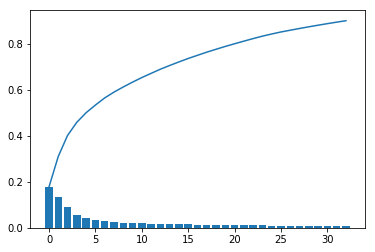

In [965]:
# Investigate the variance accounted for by each principal component.
plt.bar(x = range(pca.n_components), height = pca.explained_variance_ratio_)
plt.plot(range(pca.n_components),cum_ratio);

8 components seem to be where the cumulative ratio slows down, where single component ratio stays relatively unchanged. 

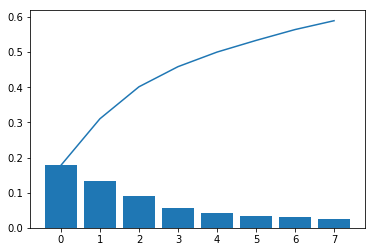

In [966]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=8)
azdias_pca = pca.fit_transform(azdias_scaled)

# compute the cumulative variance explained
cum_ratio=[sum(pca.explained_variance_ratio_[:i+1]) for i in range(pca.n_components)]

# Investigate the variance accounted for by each principal component.
plt.bar(x = range(pca.n_components), height = pca.explained_variance_ratio_)
plt.plot(range(pca.n_components),cum_ratio);

### Discussion 2.2: Perform Dimensionality Reduction

When number of components is larger than 8, there seem to be little gain of variance explained with every additional component, so I decide to retain 8 principal components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [968]:
# define a function that sorts weights of features in a principal component

def weight_map(pc, features):
    '''input: a principal component that is a pandas series that is an vector of features'weights. 
    The index are features, and values are weights of each feature to comp.
    Sort values of comp, and return a dataframe that contains features and 
    absolute weights from high to low, together with original weights'''
    weight_df = pd.DataFrame(pc, index = features, columns = ['weight'])
    weight_df['abs_weight'] = weight_df['weight'].abs()
    return weight_df.sort_values('abs_weight', ascending=False)

In [969]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

features = azdias_clean_lessNaN.columns

# view top 10 largest weights and features of first principal component
weight_map(pca.components_[0], features).head(10)   

,weight,abs_weight
MOBI_REGIO,-0.237076,0.237076
PLZ8_ANTG1,-0.222762,0.222762
PLZ8_ANTG3,0.222485,0.222485
KBA05_ANTG1,-0.220113,0.220113
PLZ8_ANTG4,0.216684,0.216684
KBA05_GBZ,-0.212504,0.212504
PLZ8_BAUMAX,0.212371,0.212371
FINANZ_MINIMALIST,-0.201029,0.201029
wealth,0.199534,0.199534
HH_EINKOMMEN_SCORE,0.195823,0.195823


In [970]:
# view top 10 largest weights and features of second principal component
weight_map(pca.components_[1], features).head(10)  

,weight,abs_weight
ALTERSKATEGORIE_GROB,0.267695,0.267695
SEMIO_REL,-0.266190,0.266190
movement_decade,-0.257806,0.257806
FINANZ_SPARER,-0.249574,0.249574
SEMIO_PFLICHT,-0.240812,0.240812
FINANZ_VORSORGER,0.239480,0.239480
SEMIO_TRADV,-0.237275,0.237275
SEMIO_ERL,0.235370,0.235370
FINANZ_UNAUFFAELLIGER,-0.231487,0.231487
SEMIO_KULT,-0.223511,0.223511


In [971]:
# view top 10 largest weights and features of third principal component
weight_map(pca.components_[2], features).head(10)  

,weight,abs_weight
ANREDE_KZ,-0.369142,0.369142
SEMIO_VERT,0.349132,0.349132
SEMIO_KAEM,-0.338871,0.338871
SEMIO_DOM,-0.313159,0.313159
SEMIO_KRIT,-0.271113,0.271113
SEMIO_SOZ,0.264023,0.264023
SEMIO_FAM,0.251355,0.251355
SEMIO_KULT,0.233123,0.233123
SEMIO_RAT,-0.215205,0.215205
FINANZ_ANLEGER,-0.187130,0.187130


### Discussion 2.3: Interpret Principal Components

PC1 increases in the opposite direction with these features: MOBI_REGIO, PLZ8_ANTG1, KBA05_ANTG1, KBA05_ANTG1, KBA05_GBZ, FINANZ_MINIMALIST. These are features of location. PC1 increases with increasing movement in the location, decreasing number of 1-2 family houses in PLZ8 region, and decreasing number of 1-2 family houses in the microcell, decreasing number of building in the microcell, and decreasing financial interest.<br>
PC1 increases in same direction with these features: PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX and Wealth. Therefore, PC1 increases with increasing number of 6-10 family houses in PLZ8 region, number of 10+ family houses, and proportion of business buildings, decreasing wealth. <br>

These features are in opposite direction of PC2: SEMIO_REL, movement_decade, FINANZ_SPARER, SEMIO_PFLICHT, SEMIO_TRADV, FINANZ_UNAUFFAELLIGER, SEMIO_KULT. This mean that PC2 increases if the person is more religious, moved in during earlier decades, more of a money-saver, more dutiful, more traditional-minded, more financially inconspicuous or more cultural-minded. <br>
These features are in same direction of PC2: ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL. This means PC2 increases with increasing estimated age, financially less prepared, less events-orientated. <br>

PC3 increase in the opposite direction as these features: ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT , FINANZ_ANLEGER. PC3 value is higher for male than female. PC3 increases with higher combative attitude, more dominant-minded, more critical-minded, or if the person is more of an investor. <br>
PC3 increases in the same direction as these features: SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT. PC3 increases if the person is less dreamful, less socially-minded, less family-minded or less cultural-minded. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [972]:
# randomly select a subset of data from the pca data
sample=azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]/10)), :].copy()

In [975]:
# Over a number of different cluster counts...
num_clusters = range(6,25)
scores = []
for num in num_clusters:
    kmeans=KMeans(num)
    kmeans.fit(sample)
    labels = kmeans.predict(sample)
    scores.append(kmeans.score(sample))

Text(0.5,0,'number of clusters')

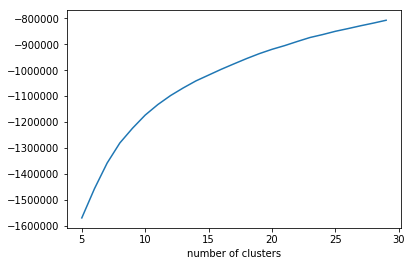

In [976]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_clusters, scores)
plt.xlabel('number of clusters')

The elbow seems to be at number of cluster = 11

In [1083]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_11=KMeans(11)
kmeans_11.fit(azdias_pca)
general_labels = kmeans_11.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

I applied KMeans to a subset of the data (10%), with number of clusters ranging from 5 to 30, and used the model's score to assess the performances at different number of clusters. I found that at around 13 cluster, the increase of score slowed down. Therefore, I decide that 13 is a reasonably good choice for number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [979]:
# Load in the customer demographics data, and feature summary
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [1054]:
# These columns had > 200000 missing values in the general populaion data, need to drop them
# from custromers data
columns_to_drop = ['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [1055]:
# clean customer data
customer_clean = clean_data(customers.copy(), columns_to_drop, feat_info)

In [1057]:
(customer_clean.isnull().sum(axis=1)==0).mean()

0.8607720248905827

More than 14% of the rows contain missing values. I will do imputation by replacing these missing values with median. 

In [1081]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# apply imputation
customers_imp = imp.transform(customer_clean)
# apply StandardScaler
customers_scaled = scaler.transform(customers_imp)
# apply PCA
customers_pca = pca.transform(customers_scaled)
# apply kmeans predictions
customers_labels = kmeans_11.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Compare the proportion of data in each cluster for the customer data and general population data

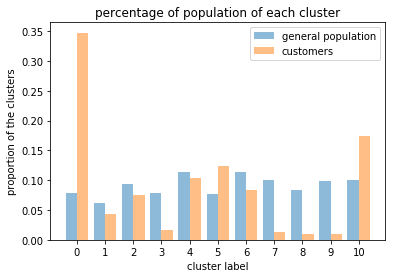

In [1119]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
bins = np.arange(-0.5, 11.5, 1)
plt.hist([general_labels, customers_labels], 
         density=True, alpha=0.5, bins=bins,
         label=['general population', 'customers'])
#plt.hist(customers_labels, density=True, alpha=0.5, rwidth=0.5, label='customers')
plt.xlabel('cluster label')
plt.xticks(range(0,11))
plt.ylabel('proportion of the clusters')
plt.title('percentage of population of each cluster')
plt.legend();

What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

customers in the first cluster is overrepresented, compared to general population

In [1125]:
# view coordinates of cluster center of first cluster
kmeans_11.cluster_centers_[0]

array([-3.28454611,  0.12092494,  2.7234541 ,  2.34542644, -0.47874528,
       -0.29351684,  0.0191035 , -0.08352427])

first cluster in very low in the first PC, close to 0 in second PC, and high in third PC, and high in 4th PC.  <br>

Since the first PC value is very low, it indicates customers in this cluster are in location of low movement, and there are high number of 1-2 family houses in the PLZ8 region and microcell, low number of 6-10 family or 10+ family houses in the PLZ8 and microcell, high number of buildings in the microcell, low number of business buildings, high financial interest, and relatively wealthy. <br>

Since the second PC is close to 0, I couldn't say firmly regarding the features that dominate PC2. <br>

The third PC is of high positive value. Therefore I infer that customers in this cluster is probably mostly male, with high combative attitude, dominant-minded, critical-minded, probably an investor, not dreamful, not socially-minded, not family-minded, and not cultural-minded. 

What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population? 

Customers in the 10th cluster is underrepresented compared to general population.

In [1127]:
# view coordinates of the cluster center of the 10th cluster
kmeans_11.cluster_centers_[9]

array([ 4.40325884e+00, -1.67183057e+00, -2.80810886e+00,  4.84444620e-01,
        1.93331527e-03, -1.17803252e-01, -8.54350660e-02,  1.16241334e-01])

This cluster has high PC1, low PC2, and low PC3. 
High PC1 means that these customers are in a region of high movement, with low number of 1-2 family houses, and high numbers of 6-10 family and 10+ family houses in the PLZ8 region and microcell, low number of buildings in the microcell, high number of business buildings, of low financial interest, and relatively unwealthy. <br>

Low PC2 value means that they are not very religious, moved in during late decades, not good at saving money, not dutiful, not traditional-minded, not financially inconspicious, not cultural-minded, and young. <br> 

Low PC3 values means that these customers are mostly female, they have less combative attitude, not dominant-minded, not critical-minded, not likely an investor, very likely dreamful, socially-minded, family-minded, and cultural-minded. 

### Discussion 3.3: Compare Customer Data to Demographics Data

Customers in first cluster is overrepresented, and customers in 10th clusters are underrepresented. The values of principal component 1 in the 1st and 10th clusters are both far away from 0, and they have opposite signs, meaning customers in the clusters live in drastically different regions. The values of principal component 3 in the 1st and 10th clusters are both far away from 0, and they also have opposite signs, meaning customers in the clusters have very opposite personality. <br>

Based on the above discovery, I suggest the company focus its attention on the regions that are of low movement, with high number of 1-2 family, and few 6-10 family or 10+ family houses in the PLZ8 region and microcell, high number of buildings in the microcell, low number of business buildings, high financial interest, and relatively wealthy. <br>

The company should also focus its attention on customers who have these characteristics in their personaly: male, high combative attitude, dominant-minded, critical-minded, probably an investor, not dreamful, not socially-minded, not family-minded, and not cultural-minded. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.